# Deep learning for predicting the class of an epidemic curve#



In this tutorial, we'll build a (small!) multilayer perceptron, train it, and use it to predict the class of a epidemic curve. To make this tutorial work, you'll need to download Python3 and install several packages (including numpy, tensorflow, pandas, and Keras). 

The dataset is available on my GitHub, [here](https://github.com/caugusta/Disease_Modelling_Club). You should download 2 files:

- train_data.csv (~200 KB)
- test_data.csv (~50 KB)




## Describing the dataset##

This dataset consists of simulated epidemic curves (counts of infectious individuals per time unit). An SIR model was used, and three types of epidemics were generated:

- one that travels relatively slowly through the population (class 0, yellow in the image below)
- one that travels very quickly through the population (class 1, grey)
- one that travels not as quickly through the population (class 2, pink)

For those of you who are interested, the population of interest was simulated locations of 413 swine farms in Sioux County, Iowa, based on the [FLAPS online farm location simulator](http://flaps.biology.colostate.edu/) from Colorado State University's Dr. Chris Burdett. At time of writing this tutorial, **FLAPS is down**, but I'm hoping it'll be up and running again soon. This is part of the dataset that was used for this paper [1].

These epidemics will look somewhat strange, because they've been padded with 0s so that each epidemic has the same length (this is necessary for input to a multilayer perceptron, more on that later).

An epidemic curve from class 0 looks like this:

4 19 17 28 30 40 51 46 31 40 29 24 11 10 9 1 3 9 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

This means that 4 farms were initially infected with the disease (day 1 had 4 infectious farms); day 2 had 19 infectious farms, etc.

The '0' on the end of this particular epidemic means that this epidemic curve was generated from class 0 (this is a fast epidemic). In this epidemic, 4+19+...+1 = 403 farms were infected. This epidemic lasted 19 days.

An epidemic curve from class 1 looks like this:

4 33 107 194 71 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1

Note there are many more infectious farms at the beginning. 412 farms got infected in 6 days - that's a wildfire-fast epidemic! And the '1' at the end denotes that this epidemic belongs to class 1.

An epidemic curve from class 2 looks like this:

4 20 40 79 104 86 49 21 6 2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2

This epidemic lasted 11 days.

If you were to graph the epidemic curves (number of infectious farms vs index of day), it would look like this:

[IMAGE](https://github.com/caugusta/Disease_Modelling_Club/blob/master/ThreeEpidemics_DMC-1.png)

These three classes of epidemic look very different from one another, so we would expect a classifer to perform very well. This is an extreme example, to show how the classifier works, but in reality there could be some epidemics from the yellow group that look more like epidemics from the pink group. The power of these types of models is in how they learn to distinguish types of epidemic curves _even when those epidemic curves look very similar_. For this tutorial, the goal is to understand more about how a multilayer perceptron works, so that's another topic for another day.


## Building a multilayer perceptron (MLP) for classifying epidemic curves##


Okay, let's get started with some code. In Python, the first thing we do is import the various modules we'll be using. If you run the code below, there shouldn't be any output, except perhaps 'Using TensorFlow backend'.


In [130]:
import keras
import string
import tensorflow as tf
import numpy as np
from keras import Model
from keras.layers import Input, Dense
from keras.optimizers import SGD
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

### Reading in the data##

Now we want to read in the data we're planning to use. We'll load the data, and manipulate it into a useable form.

Keras, the API we'll be using to build our MLP, requires numpy arrays as input. So we have to convert each of our epidemic curves to numpy arrays.

In [112]:
#Anything preceded by # in Python is a comment.

seed = 2018
np.random.seed(seed) #this is to make sure all our results are reproducible.

#Reading in the data

#If you saved the files elsewhere, include the full path in the ' ' below. 
# For example, if you saved train_data.csv in /my/dir, 
# which is a sub-directory of the current directory, then the next line should read:
# with open('./my/dir/train_data.csv', 'r') as f:

with open('train_data.csv', 'r') as f: 
    train_data = f.readlines()
    
with open('test_data.csv', 'r') as f:
    test_data = f.readlines()
    
#Right now, train_data is a list of strings.    
#We can visualize the first line of the training data to make sure things read in properly:

#train_data[0]
#'4 19 17 28 30 40 51 46 31 40 29 24 11 10 9 1 3 9 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 "0"\n'

train_no_newline = [s.rstrip() for s in train_data] #remove \n from the end of each line

#train_no_newline[0]
#'4 19 17 28 30 40 51 46 31 40 29 24 11 10 9 1 3 9 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 "0"'

train_no_quotes = [s.replace('"', '') for s in train_no_newline] # remove "" from 0 at end.

#train_no_quotes[0]
#'4 19 17 28 30 40 51 46 31 40 29 24 11 10 9 1 3 9 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0'

#Convert the string values to integers
train_as_list = list()
for i in range(len(train_no_quotes)):
    for j in range(len(train_no_quotes[i].split())):
        train_as_list.append(int(train_no_quotes[i].split()[j]))

#Convert the list to an array

train_array = np.asarray(train_as_list)

train_array = train_array.reshape((2400, 34))

#train_array[0,:] NOTE how indexing an array is different! 
#There are 2 dimensions. We want row 0 and all columns printed out.

#array([ 4, 19, 17, 28, 30, 40, 51, 46, 31, 40, 29, 24, 11, 10,  9,  1,  3,
#        9,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

#Now do the same for the test set.

test_no_newline = [s.rstrip() for s in test_data]
test_no_quotes = [s.replace('"', '') for s in test_no_newline]

test_as_list = list()
for i in range(len(test_no_quotes)):
    for j in range(len(test_no_quotes[i].split())):
        test_as_list.append(int(test_no_quotes[i].split()[j]))
        
test_array = np.asarray(test_as_list)
test_array = test_array.reshape((600, 33))

### Fixing the class label

In our dataset, we have some integers that are true integers (counts of infectious farms each day), and we have some integers that are just there to denote that the epidemic belongs to class 0, class 1, or class 2. Those are stored in the last column of the array.

We want to make sure Keras understands that 0, 1, 2 at the end of the array just means a class label, and is not part of the counts of infectious farms.

In [125]:
train_no_labels = train_array[:, :-1] #means "all rows and all columns except last column"
train_labels = train_array[:,-1] #means "all rows and only last column"

#With thanks to [2]
encoder = LabelEncoder()
encoder.fit(train_labels)
Y_train = encoder.transform(train_labels)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(Y_train)

test_no_labels = test_array[:,:-1]
test_labels = test_array[:,-1]

encoder = LabelEncoder()
encoder.fit(test_labels)
Y_test = encoder.transform(test_labels)
dummy_y_test = np_utils.to_categorical(Y_test)

#Now, when I was making the datasets, I should have ensured 
#the training set had the same number of columns as the test set.
#Fixing that now....
N = test_no_labels.shape[0] #number of rows
M = test_no_labels.shape[1] #number of columns
test_no_labels_2 = np.zeros((N, M+1)) #create a matrix of 0s with N rows and M+1 columns
test_no_labels_2[:, :-1] = test_no_labels #insert test epidemics up to last column

#test_no_labels.shape #(600, 32)
#test_no_labels_2.shape #(600, 33)
#train_no_labels.shape #(2400, 33) 

test_no_labels = test_no_labels_2 #reassigning the variable name.

### Normalizing the data

As is common in machine learning, we should normalize the input before we feed it in to our model. That means we'll subtract the mean of the training data and divide by the standard deviation. 

In [126]:
train_use = (train_no_labels - np.mean(train_no_labels))/np.std(train_no_labels)

#train_use[0,:]
#array([-0.28472025,  0.2416698 ,  0.17148446,  0.55750384,  0.62768918,...])

test_use = (test_no_labels - np.mean(test_no_labels))/(np.std(test_no_labels))

### Building the model

In our MLP, we will need an input layer, two hidden layers, and an output layer. This will be a very small network, because we want to be able to train this locally. If you're looking this up later, we're using Keras's functional API.

In [135]:
#Our MLP will have four layers: an input layer, two hidden layers, and an output layer
#the input layer has size 33 because that's the length of our epidemic curves
#it will pass these epidemics to the first hidden layer, hidden_1

#hidden_1 with 10 hidden units will compute sigma(W_1*X + b_1) and pass it to the next layer
#hidden_2 with 8 hidden units will compute sigma(W_2*hidden_1 + b_2) and pass it to the next layer

#the output layer with 3 output units will compute 
#the probability that the epidemic curve belongs to each class


input_layer = Input(shape=(33,), name='input_layer') #take in an unspecified number of epidemic curves, each of length 33
hidden_1 = Dense(10, activation="sigmoid", name="hidden_1")(input_layer) # a hidden layer with 10 units that takes in the input
hidden_2 = Dense(10, activation="sigmoid", name="hidden_2")(hidden_1) #a hidden layer with 5 units that takes in compute values from the previous hidden layer
output_layer = Dense(3, activation="softmax", name="output_layer")(hidden_2) #the output layer

model = Model(inputs=[input_layer], outputs=output_layer)

#We can see the shape of each layer, and the number of parameters in the model,
#using summary()

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 33)                0         
_________________________________________________________________
hidden_1 (Dense)             (None, 10)                340       
_________________________________________________________________
hidden_2 (Dense)             (None, 10)                110       
_________________________________________________________________
output_layer (Dense)         (None, 3)                 33        
Total params: 483
Trainable params: 483
Non-trainable params: 0
_________________________________________________________________


### Training the model

Now that we've built the model, we have to find optimal values for each of the 209 parameters. The process of finding the optimal values is called model training.

When we train a model, we want the model to learn abstract features that identify an epidemic as belonging to a class. That means we need to shuffle the dataset - that is, we need to randomize the order, so our model doesn't learn that the first 100 epidemic curves all belong to the same class. We'll do this in model.fit() below. It's true by default but we'll state it explicitly anyway.

Also, usefully, we can provide the test data at the same time. The model will see only the training data while we're trying to update parameter values using stochastic gradient descent (SGD), but after each epoch, it'll see the validation data (but these will not inform parameter updates. This is just a way of seeing how the model is doing so far).

In [136]:
num_epochs = 10 #this is the number of times we'll iterate over the training dataset.
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

#We'll feed 20 epidemic curves in to the model at a time.
model_training = model.fit(train_use, dummy_y, validation_data = (test_use, dummy_y_test), epochs=num_epochs, batch_size=20, shuffle=True, verbose=2)
    

Train on 2400 samples, validate on 600 samples
Epoch 1/10
 - 1s - loss: 1.0833 - acc: 0.4279 - val_loss: 1.0458 - val_acc: 0.6667
Epoch 2/10
 - 0s - loss: 1.0327 - acc: 0.7250 - val_loss: 1.0205 - val_acc: 0.9883
Epoch 3/10
 - 0s - loss: 1.0093 - acc: 0.9942 - val_loss: 0.9975 - val_acc: 0.9950
Epoch 4/10
 - 0s - loss: 0.9857 - acc: 0.9892 - val_loss: 0.9726 - val_acc: 0.9983
Epoch 5/10
 - 0s - loss: 0.9589 - acc: 0.9929 - val_loss: 0.9444 - val_acc: 1.0000
Epoch 6/10
 - 0s - loss: 0.9284 - acc: 0.9987 - val_loss: 0.9116 - val_acc: 0.9967
Epoch 7/10
 - 0s - loss: 0.8935 - acc: 0.9958 - val_loss: 0.8743 - val_acc: 1.0000
Epoch 8/10
 - 0s - loss: 0.8538 - acc: 0.9962 - val_loss: 0.8326 - val_acc: 0.9967
Epoch 9/10
 - 0s - loss: 0.8100 - acc: 0.9992 - val_loss: 0.7873 - val_acc: 0.9917
Epoch 10/10
 - 0s - loss: 0.7634 - acc: 0.9958 - val_loss: 0.7394 - val_acc: 0.9983


### Visualizing the results

Now that we have a working model of what each type of epidemic curve looks like, with an accuracy of greater than 99%, let's visualize the results. This code is taken directly from [3]. 

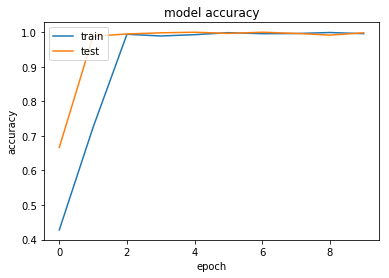

In [137]:
# summarize history for accuracy
plt.plot(model_training.history['acc'])
plt.plot(model_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

These results will not match what's in the paper, because it's a gross oversimplification of the problem. We only have 3 classes here, whereas in the paper we had up to 16 classes. We also only tried an MLP here, with a very simple formulation, and didn't explore any hyperparameter selection. A hyperparameter has to do with model setup. It can be anything from the number of hidden units per layer, to the way we initialize the hidden units, to the optimizer we choose, etc. Here we focused on epidemics that were very easy to classify, to make sure model training would run smoothly.

### Where to get more info

The complete code for this entire tutorial, all together, is available on my GitHub [here](https://github.com/caugusta/Disease_Modelling_Club/blob/master/code_from_Disease_Modelling_Club_Apr_19_2018.py) for anyone who would like to play with it! If you use these data in a presentation or publication, please cite my advisors and me (citation [1] below).

If you're looking for more resources, I highly recommend machinelearningmastery (citations [2] and [3] below). You can also read the paper [Deep Learning: An Introduction for Applied Mathematicians](https://arxiv.org/abs/1801.05894), which provides a really good overview of what's going on in deep neural networks.

[1] Augusta, C., R. Deardon and G. W. Taylor. Deep learning for classifying epidemic curves. [Under review] Spatial and Spatio-Temporal Epidemiology. 

[2] https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/

[3] https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/